# Detecting Diabetes: Modeling 

## Import Libraries

In [30]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from functools import reduce

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

import random
random.seed(42)

## Load Data

In [31]:
# read in the data
df=pd.read_csv('./data/diabetes_clean.csv')
df.head()

,Unnamed: 0,PAQ650,PAQ605,PAQ620,PAQ635,PAQ665,RIAGENDR,RIDAGEYR,RIDRETH3,INDFMPIR,...,BMXWAIST,BMXHIP,BPXOSY2,BPXODI2,DIQ010,MCQ300C,SMQ040,RHQ160,BPQ020,wh_ratio
0,1,0,0,0,0,0,2,13,1,0.83,...,63.800000,85.000000,109.00000,68.000000,0,0,2,0,0,0.750588
1,2,0,0,0,0,0,1,2,3,3.06,...,41.200000,105.695821,119.74237,71.508478,0,0,2,0,0,0.389798
2,3,1,2,2,2,1,2,29,6,5.00,...,117.900000,126.100000,99.00000,55.000000,0,1,2,0,2,0.934972
3,4,1,2,2,2,2,2,21,2,5.00,...,90.201228,105.695821,119.74237,71.508478,0,2,2,0,2,0.853404
4,5,2,1,1,2,2,2,18,3,1.66,...,90.201228,105.695821,119.74237,71.508478,0,0,2,0,2,0.853404


In [32]:
# drop Unnamed: 0 column
df.drop(columns='Unnamed: 0', inplace=True)

In [33]:
# check for null values and dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13671 entries, 0 to 13670
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PAQ650    13671 non-null  int64  
 1   PAQ605    13671 non-null  int64  
 2   PAQ620    13671 non-null  int64  
 3   PAQ635    13671 non-null  int64  
 4   PAQ665    13671 non-null  int64  
 5   RIAGENDR  13671 non-null  int64  
 6   RIDAGEYR  13671 non-null  int64  
 7   RIDRETH3  13671 non-null  int64  
 8   INDFMPIR  13671 non-null  float64
 9   BMXBMI    13671 non-null  float64
 10  BMXWAIST  13671 non-null  float64
 11  BMXHIP    13671 non-null  float64
 12  BPXOSY2   13671 non-null  float64
 13  BPXODI2   13671 non-null  float64
 14  DIQ010    13671 non-null  int64  
 15  MCQ300C   13671 non-null  int64  
 16  SMQ040    13671 non-null  int64  
 17  RHQ160    13671 non-null  int64  
 18  BPQ020    13671 non-null  int64  
 19  wh_ratio  13671 non-null  float64
dtypes: float64(7), int64(13)
mem

---
# Modeling

---
 **Considerations:**

+ We would care about interpretability to understand the relationship between features with the likelihood of diabetes. 

+ We have two outcomes and need to use a binary classifier 

+ We would optimize for false negatives:

    + **False positives**  (i.e. we guess a person is likely to be suffering from diabetes but are wrong) are okay.
        - Life style changes or other interventions that a person might undergo if falsely diagnosed could be beneficial even without having the disease.
    + **False negatives** (i.e. we guess a person is not diabetic but are wrong) are less preferable.
        - Not identifying respondents with diabetes means a  missed diagnosis and can lead to unfavorable consequences. Intuitively, we know that proclaiming all data points as negative (not diabetic) in the disease diagnosis problem isn’t helpful, and, instead, we should focus on identifying the positive cases. 

+ The app is a preliminary disease screening of individuals for follow-up interventions, so we would probably want a higher recall score. However, when recall increases, precision decreases. We want to find all patients who actually have the disease and we can accept a low precision. If we accidentally find some patients have the disease who actually don’t have it. The cost of the follow-up intervention isn’t high compared to the cost of a missed diagnosis.  

- Here are a list of models that we are going to train:

    + Logistic Regression
    + Random forest
    + Knn
    + Multinomial Naive bayes 
    + Gradient Boosting

### Null Model

- For classification problems, we build our null model based on the most frequent value in the train data.

In [34]:
# baseline accuracy 
df['DIQ010'].value_counts(normalize=True)

0    0.873674
1    0.126326
Name: DIQ010, dtype: float64

The baseline accuracy is 87%. We have a class imbalance; let's run a few models and see how they do.
This means that a dumb model that always predicts 0 would be right 87% of the time.

We will use the following eight potential predictive features as a start:

    - age
    - waist-hip ratio
    - BMI
    - physical activity features

In [35]:
df= df[['PAQ650', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ665','RIDAGEYR','BMXBMI','wh_ratio', 'DIQ010']]

In [36]:
# List of columns that will be dummified
cat_cols = ['PAQ650', 'PAQ605', 'PAQ620', 'PAQ635', 'PAQ665']
# Dummify catagorical columns
df= pd.get_dummies(df, columns=cat_cols, drop_first=True)
# # concatenate dummies with df_1
# df_1= pd.concat([df, dum], axis=1) 

In [37]:
df.columns

Index(['RIDAGEYR', 'BMXBMI', 'wh_ratio', 'DIQ010', 'PAQ650_1', 'PAQ650_2',
       'PAQ605_1', 'PAQ605_2', 'PAQ620_1', 'PAQ620_2', 'PAQ635_1', 'PAQ635_2',
       'PAQ665_1', 'PAQ665_2'],
      dtype='object')

In [38]:
# set up X and y
X = df.drop(columns = ['DIQ010'])
y = df['DIQ010']

In [39]:
# a function for metrics of a binary classification
def binary_metrics(X_train, y_train, X_test, y_test, model):
    y_pred=model.predict(X_test)

    acc_test=metrics.accuracy_score(y_test, y_pred)
    recall_test=metrics.recall_score(y_test, y_pred)
    
    y_preds_train = model.predict(X_train)
    acc_rain=metrics.accuracy_score(y_train, y_preds_train)
    recall_rain=metrics.recall_score(y_train, y_preds_train)
    
    print('\nTrain Accuracy:', round(acc_rain,8))
    print('Test Accuracy:', round(acc_test,8))
    
    print('\nTrain Recall:', round(recall_rain,8))
    print('Test Recall:', round(recall_test,8))
    
    y_pred_test = model.predict(X_test)
    print(classification_report(y_test, y_pred_test))
    
    print('\n Confusion Matrix of Test Data')
    plot_confusion_matrix(model, X_test, y_test, cmap='Oranges', values_format='d')
    
    metrics.plot_roc_curve(model, X_test, y_test) 
    plt.show()

## Logistic Regression

In [40]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [41]:
log=LogisticRegression(max_iter = 2000)
log.fit(X_train, y_train)

LogisticRegression(max_iter=2000)


Train Accuracy: 0.87467083
Test Accuracy: 0.87653599

Train Recall: 0.08416988
Test Recall: 0.09490741
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2986
           1       0.57      0.09      0.16       432

    accuracy                           0.88      3418
   macro avg       0.73      0.54      0.55      3418
weighted avg       0.84      0.88      0.84      3418


 Confusion Matrix of Test Data


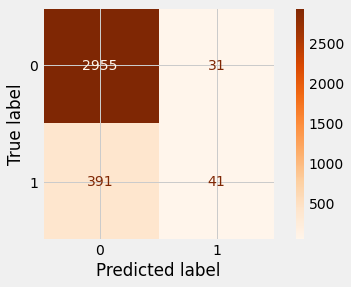

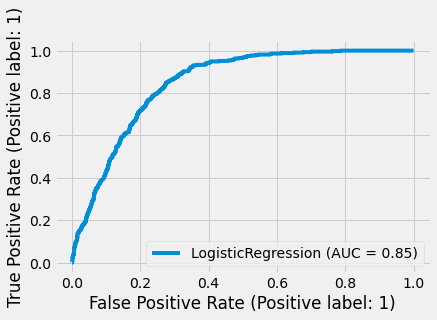

In [42]:
binary_metrics(X_train, y_train, X_test, y_test, log)

> ### Logistic regression Weighted Class

In [43]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [45]:
lr_pipe = Pipeline([
    ('lr', LogisticRegression()),
])

# find the optimal hyperparameters.
pipe_params ={
    'lr__C' : [1.0, 0.1, 0.01, 0.001],
    'lr__penalty': ['l1', 'l2','none'],
    'lr__class_weight': ['balanced'],
    'lr__max_iter': [3000],
    'lr__solver': ['saga']
    

}

# Gridsearch using the specified hyper parameters.
lr_weight = GridSearchCV(
    lr_pipe,
    pipe_params,
    cv = 5,
    n_jobs = -1,
    verbose = 2
    , scoring = 'recall'
    , return_train_score=True
)

# Fit our training data to the Grisearch.
lr_weight.fit(X_train, y_train)
print(lr_weight.best_params_)
print(lr_weight.best_estimator_)
print(lr_weight.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'lr__C': 0.1, 'lr__class_weight': 'balanced', 'lr__max_iter': 3000, 'lr__penalty': 'l1', 'lr__solver': 'saga'}
Pipeline(steps=[('lr',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=3000, penalty='l1',
                                    solver='saga'))])
0.8455598455598455



Train Accuracy: 0.72417829
Test Accuracy: 0.7284962

Train Recall: 0.84710425
Test Recall: 0.85648148
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      2986
           1       0.30      0.86      0.44       432

    accuracy                           0.73      3418
   macro avg       0.64      0.78      0.63      3418
weighted avg       0.89      0.73      0.77      3418


 Confusion Matrix of Test Data


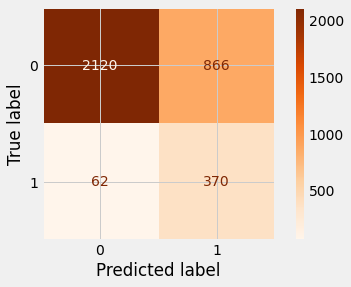

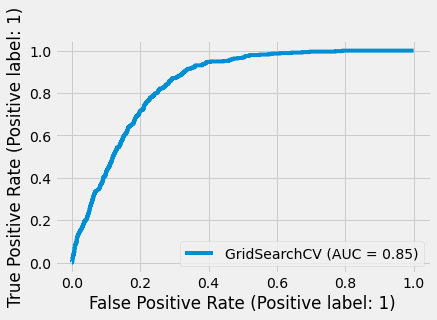

In [52]:
# Run Function to evaluate our model
binary_metrics(X_train, y_train, X_test,y_test, lr_weight)

> ### Random Forest Weighted Class: 


In [47]:
rf = RandomForestClassifier()

# gridsearch 
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'max_features': ['sqrt', .5],
    'bootstrap': [True, False],
    'random_state': [42],
    'class_weight': ["balanced_subsample"]
}
met_grid= ['accuracy', 'recall']
gs_rf = GridSearchCV(rf
                     , rf_params
                     , cv=5
                     , n_jobs=-1
                     , verbose=1
                     , scoring='recall'
                    , return_train_score=True)
gs_rf.fit(X_train, y_train)
print(gs_rf.best_score_)
gs_rf.best_params_

# gridsearch optimization
print('best score:', gs_rf.best_score_)
print('best parameters:', gs_rf.best_params_)
print('recall on train data:', gs_rf.score(X_train, y_train))
print('recall on test data:', gs_rf.score(X_test, y_test))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
0.9088803088803088
best score: 0.9088803088803088
best parameters: {'bootstrap': False, 'class_weight': 'balanced_subsample', 'max_depth': 2, 'max_features': 0.5, 'n_estimators': 150, 'random_state': 42}
recall on train data: 0.9104247104247104
recall on test data: 0.9143518518518519



Train Accuracy: 0.64985858
Test Accuracy: 0.66032768

Train Recall: 0.91042471
Test Recall: 0.91435185
              precision    recall  f1-score   support

           0       0.98      0.62      0.76      2986
           1       0.26      0.91      0.40       432

    accuracy                           0.66      3418
   macro avg       0.62      0.77      0.58      3418
weighted avg       0.89      0.66      0.72      3418


 Confusion Matrix of Test Data


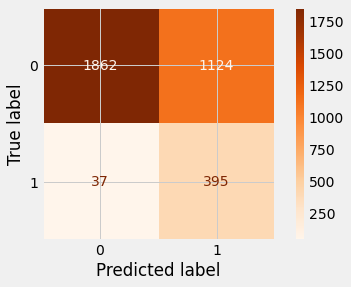

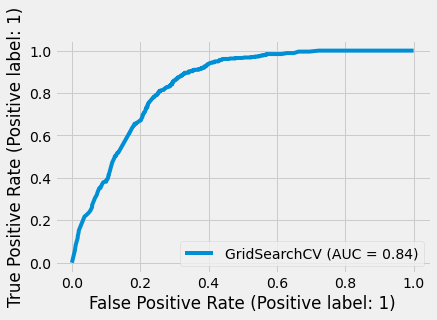

In [51]:
# Run Function to evaluate our model
binary_metrics(X_train, y_train, X_test,y_test, gs_rf)


> ### Random Forest Smote and Undersampling 

In [49]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [50]:
smo = SMOTE()
pipe = Pipeline([
    ('over', SMOTE(random_state=42)), 
    ('rf', RandomForestClassifier(n_estimators=150, 
                                  max_depth=2, 
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  max_features=0.5,
                                  bootstrap=False,
                                  random_state=42))
])


# sets the pipe params
pipe_params = {'over__sampling_strategy':[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#                'under__sampling_strategy' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
              }
met_grid= ['accuracy', 'recall']

# Instantiates the gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=3, 
                  n_jobs=4
                     , verbose=1
                     , scoring='recall'
                    , return_train_score=True
                )
# Fit training data
gs.fit(X_train, y_train)

# gridsearch optimization
print('best score:', gs.best_score_)
print('best parameters:', gs.best_params_)
print('recall on train data:', gs.score(X_train, y_train))
print('recall on test data:', gs.score(X_test, y_test))


Fitting 3 folds for each of 7 candidates, totalling 21 fits
best score: 0.8625379536535762
best parameters: {'over__sampling_strategy': 1.0}
recall on train data: 0.9042471042471042
recall on test data: 0.9027777777777778



Train Accuracy: 0.66234273
Test Accuracy: 0.66705676

Train Recall: 0.9042471
Test Recall: 0.90277778
              precision    recall  f1-score   support

           0       0.98      0.63      0.77      2986
           1       0.26      0.90      0.41       432

    accuracy                           0.67      3418
   macro avg       0.62      0.77      0.59      3418
weighted avg       0.89      0.67      0.72      3418


 Confusion Matrix of Test Data


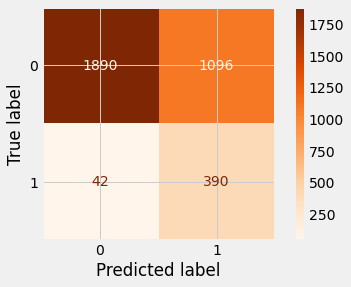

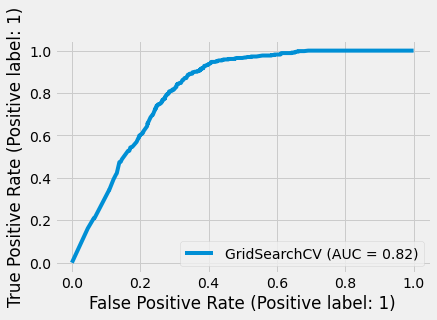

In [53]:
# Run Function to evaluate our model
binary_metrics(X_train, y_train, X_test,y_test, gs)

In [54]:
smo = SMOTE()
pipe = Pipeline([ 
    ('under',RandomUnderSampler(random_state=42)), 
    ('rf', RandomForestClassifier(n_estimators=150, 
                                  max_depth=2, 
                                  min_samples_leaf=2,
                                  min_samples_split=2,
                                  max_features=0.5,
                                  bootstrap=False,
                                  random_state=42))
])



pipe_params = {'under__sampling_strategy' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
              }
met_grid= ['accuracy', 'recall']

# Instantiates the gridsearch
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=3, 
                  n_jobs=4
                     , verbose=1
                     , scoring='recall'
                    , return_train_score=True
                )
# Fit training data
gs.fit(X_train, y_train)

# gridsearch optimization
print('best score:', gs.best_score_)
print('best parameters:', gs.best_params_)
print('recall on train data:', gs.score(X_train, y_train))
print('recall on test data:', gs.score(X_test, y_test))



Fitting 3 folds for each of 7 candidates, totalling 21 fits
best score: 0.8980765374810232
best parameters: {'under__sampling_strategy': 0.9}
recall on train data: 0.9088803088803089
recall on test data: 0.9120370370370371



Train Accuracy: 0.65600312
Test Accuracy: 0.66413107

Train Recall: 0.90888031
Test Recall: 0.91203704
              precision    recall  f1-score   support

           0       0.98      0.63      0.77      2986
           1       0.26      0.91      0.41       432

    accuracy                           0.66      3418
   macro avg       0.62      0.77      0.59      3418
weighted avg       0.89      0.66      0.72      3418


 Confusion Matrix of Test Data


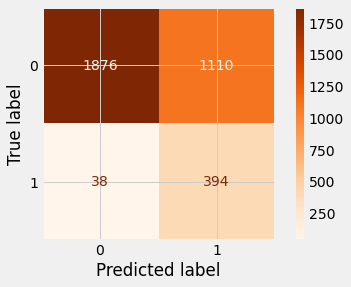

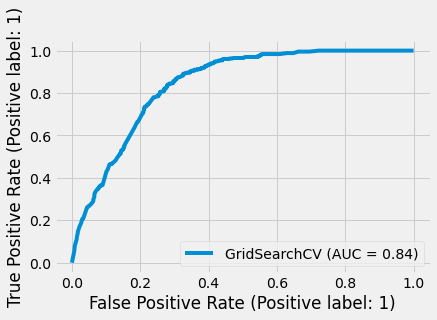

In [55]:
# Run Function to evaluate our model
binary_metrics(X_train, y_train, X_test,y_test, gs)


> ### Logistic Regression Smote and Undersampling

In [ ]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [56]:
pipe = Pipeline([
    ('over', SMOTE(random_state=42)),  
    ('logreg', LogisticRegression(class_weight = 'balanced',
                                 max_iter= 1000))
])

# sets the pipe params
pipe_params = {'over__sampling_strategy':[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 
              }

met_grid= ['accuracy', 'recall']

# Instantiates the gridsearch
gs_logreg = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=3, 
                  n_jobs=4
                     , verbose=1
                     , scoring='recall'
                    , return_train_score=True
                )


# Fit training data
gs_logreg.fit(X_train, y_train)

# gridsearch optimization
print('best score:', gs_logreg.best_score_)
print('best parameters:', gs_logreg.best_params_)
print('recall on train data:', gs_logreg.score(X_train, y_train))
print('recall on test data:', gs_logreg.score(X_test, y_test))



Fitting 3 folds for each of 7 candidates, totalling 21 fits
best score: 0.7420995531494371
best parameters: {'over__sampling_strategy': 0.4}
recall on train data: 0.7559845559845559
recall on test data: 0.7615740740740741



Train Accuracy: 0.75772945
Test Accuracy: 0.75921592

Train Recall: 0.75598456
Test Recall: 0.76157407
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      2986
           1       0.31      0.76      0.44       432

    accuracy                           0.76      3418
   macro avg       0.64      0.76      0.65      3418
weighted avg       0.88      0.76      0.80      3418


 Confusion Matrix of Test Data


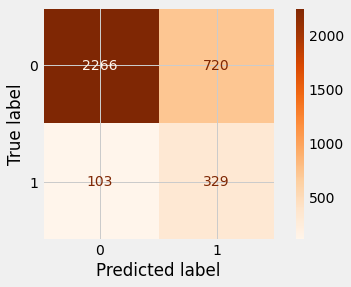

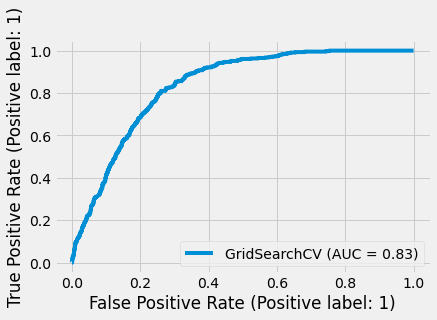

In [57]:
binary_metrics(X_train, y_train, X_test, y_test, gs_logreg)

In [58]:
pipe = Pipeline([
#     ('over', SMOTE(random_state=42)), 
    ('under',RandomUnderSampler(random_state=42)), 
    ('logreg', LogisticRegression(class_weight = 'balanced',
                                 max_iter= 1000))
])

# sets the pipe params
pipe_params = {
#     'over__sampling_strategy':[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
               'under__sampling_strategy' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  
              }

met_grid= ['accuracy', 'recall']

# Instantiates the gridsearch
gs_logreg = GridSearchCV(pipe, 
                  param_grid=pipe_params,
                  cv=3, 
                  n_jobs=4
                     , verbose=1
                     , scoring='recall'
                    , return_train_score=True
                )


# Fit training data
gs_logreg.fit(X_train, y_train)

# gridsearch optimization
print('best score:', gs_logreg.best_score_)
print('best parameters:', gs_logreg.best_params_)
print('recall on train data:', gs_logreg.score(X_train, y_train))
print('recall on test data:', gs_logreg.score(X_test, y_test))




Fitting 3 folds for each of 7 candidates, totalling 21 fits
best score: 0.8494421529030965
best parameters: {'under__sampling_strategy': 0.8}
recall on train data: 0.844015444015444
recall on test data: 0.8611111111111112



Train Accuracy: 0.72310543
Test Accuracy: 0.72966647

Train Recall: 0.84401544
Test Recall: 0.86111111
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      2986
           1       0.30      0.86      0.45       432

    accuracy                           0.73      3418
   macro avg       0.64      0.79      0.63      3418
weighted avg       0.89      0.73      0.77      3418


 Confusion Matrix of Test Data


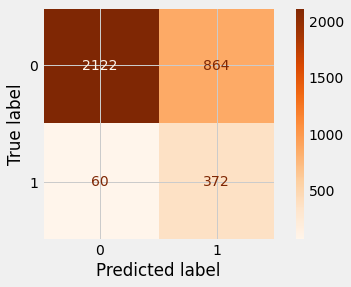

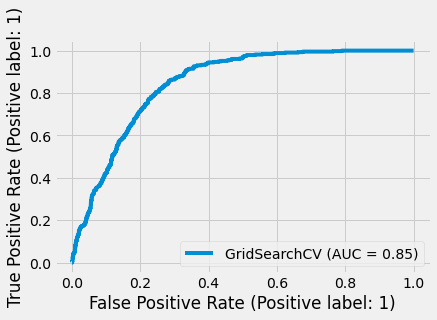

In [59]:
binary_metrics(X_train, y_train, X_test, y_test, gs_logreg)

### Gradient Boosting

In [60]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [61]:
gb_clf = GradientBoostingClassifier()

param_grid_gb = {'n_estimators': [50, 100, 500],
                    'learning_rate': [1, 0.6, 0.2],
                    'max_features': ['auto', 'sqrt'],
                    'min_samples_leaf': [2, 5],
                    'min_samples_split': [2, 5, 10],
                    'max_depth':[10, 30, 50],
                    'random_state': [42]
                 }

In [62]:
#xgb_grid_search_res = GridSearchCV(xgb_clf, param_grid_xgb, cv=10, scoring="accuracy", return_train_score=True, verbose=True, n_jobs=-1)
gb_gs= GridSearchCV(
    estimator=gb_clf
    , param_grid= param_grid_gb
    , cv=3
    , scoring="recall"
    , return_train_score=True
    , verbose=1, n_jobs=-1)
gb_gs.fit(X_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [1, 0.6, 0.2],
                         'max_depth': [10, 30, 50],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 500], 'random_state': [42]},
             return_train_score=True, scoring='recall', verbose=1)

In [63]:
# gridsearch optimization
print('best score:', gb_gs.best_score_)
print('best parameters:', gb_gs.best_params_)
print('recall on train data:', gb_gs.score(X_train, y_train))
print('recall on test data:', gb_gs.score(X_test, y_test))



best score: 0.5289504024519492
best parameters: {'learning_rate': 1, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500, 'random_state': 42}
recall on train data: 0.5544401544401545
recall on test data: 0.4837962962962963


Train Accuracy: 0.55444015
Test Accuracy: 0.4837963

Train Recall: 0.55444015
Test Recall: 0.4837963

Train Specificity: 0.76590757
Test Specificity: 0.73777629

Train Precision: 0.25506217
Test Precision: 0.21068548

 Confusion Matrix of Test Data


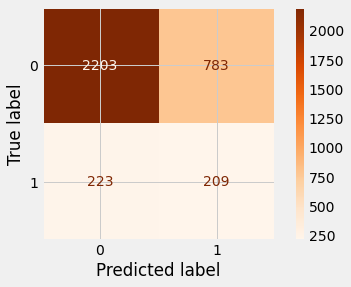

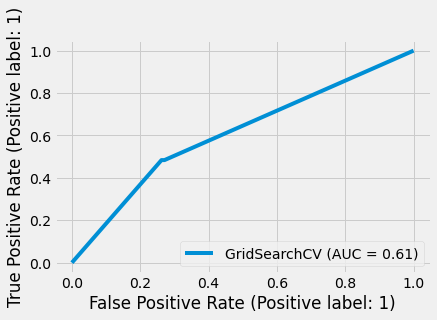

In [64]:
# Run Function to evaluate our model
class_metrics(X_train, y_train, X_test,y_test, gb_gs)

Eventhough the accuracy score is good for all the models. Our recall score is very low in all of the models. For example the logsitic regression model has a lot of false negatives than false positives which explains the low recall score. This could be due to data imbalance. Lets try and use the weighted class technique to help lower the false negatives.